<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Time series first notebook</h1>
#### Thanks again to Leo Siqueira for contributions

Author: Wei-Ming Tsai
Date: 03/22/18

<div style="clear:both"></div>
</div>

<hr style="height:2px;">
#### Dataset: NOAA-OLR daily, 2010-2016, over tropical regions between 10S and 10N

### Methods of time series analysis
1. <a href="#stationary">First thing: establishing stationarity</a>
1. <a href="#composing">Composing a sum of Fourier harmonics</a>
1. <a href="#decomposing">Decomposing, using orthogonality</a>
1. <a href="#spectrum">Variance density by frequency (power spectrum)</a>
1. <a href="#autocorrelation">Lagged (auto) correlation/covariance</a>
1. <a href="#AR1noise">AR1 model of geophysical processes</a>

--------

In [1]:
%matplotlib inline

import os 
import matplotlib.pyplot as plt
# GridSpec lets us align plots carefully 
from matplotlib import gridspec

import scipy.stats as stats
import numpy as np
from netCDF4 import Dataset
from numpy.random import rand
from pylab import rcParams, pcolor, show, colorbar, xticks, yticks, title, figure

rcParams['figure.figsize'] = (10, 5)

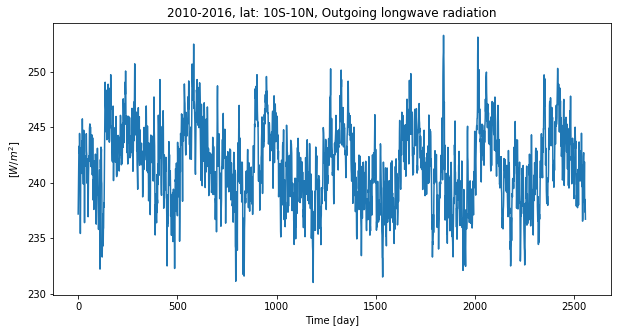

In [38]:
# read netcdf data: NOAA-OLR daily
os.chdir('/Users/willytsai/MPO624_data/data')
nc_fid=Dataset('olr_timeseries_latnp10.nc'); # domain average 10S-10N, 2010-2016
olr=np.squeeze(nc_fid.variables['olr'][:]);
plt.plot(olr)
plt.xlabel('Time [day]');plt.ylabel('$[W/m^2]$');
plt.title('2010-2016, lat: 10S-10N, Outgoing longwave radiation');

----------------
<a name="spectrum"></a>
### FFT is the "fast" mathemagic for a Fourer transform

Coefficients like the one above make up the _cosine part of the amplitude spectrum_ (the _real part_ of the complex spectrum). The _sine part_ is in the imaginary part. 

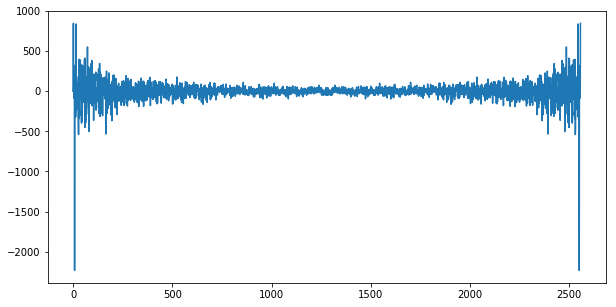

In [3]:
# Take the simple FFT, after removing the mean

Vp = olr - olr.mean() # olr anomaly

#To match the sign above, roll the array so it starts at t=0. 
# Vp = np.roll(Vp, int(-NT/2) ) Too fussy: just know the sign is opposite

# BOOM! Notice there is no time axis, just the values, hence the roll issue above
Vspec = np.fft.fft( Vp ) # spectrum -- frequency field

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax=plt.subplots(1,1) 
ax.plot(Vspec.real)
plt.show()
#ax.plot(Vspec.imag)

Text(0,0.5,u'Some measure of cosine component amplitude')

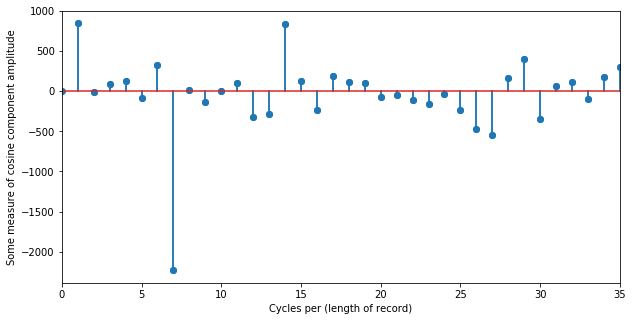

In [4]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)
NT=len(olr);N=30;
freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, Vspec.real)
ax.set_xlim([0,N + 5])
ax.set_xlabel('Cycles per (length of record)')
ax.set_ylabel('Some measure of cosine component amplitude')

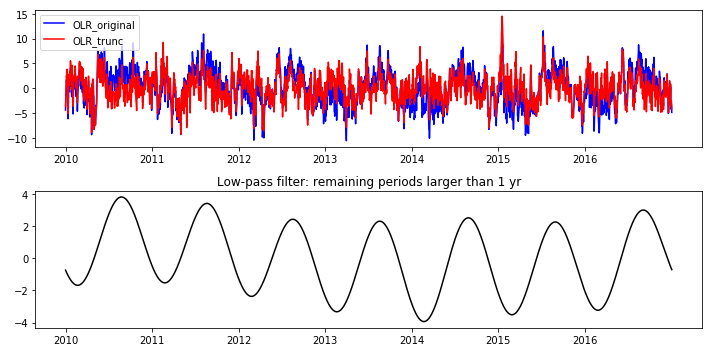

In [50]:
# Mess with the spectrum and reconstruct (a way of filtering)
# Try to remove specfic freqency => high, low pass filter

# Truncate the frequencies higher then TRUNC cycles per record length
TRUNC = 8 # 7 cycles per record (2555 day)= 1 year

Vspec_trunc = Vspec.copy()
Vspec_trunc[np.where(freqs < TRUNC)] *= 0. # filter 
Vrecon = np.fft.ifft(Vspec_trunc).real # reverse filtered fft back to time series by ifft

# How's the reconstruction? 
fig,(ax1,ax2)=plt.subplots(2,1) 
ax1.plot(Vp,      color='blue')
ax1.plot(Vrecon,  color='red')
ax1.set_xticks(np.arange(0,2555,365));
ax1.set_xticklabels(['2010','2011','2012','2013','2014','2015','2016'])
ax1.legend(['OLR_original','OLR_trunc'],loc=2)
          
ax2.plot(Vp-Vrecon,      color='black')
ax2.set_xticks(np.arange(0,2555,365));
ax2.set_xticklabels(['2010','2011','2012','2013','2014','2015','2016'])
plt.title('Low-pass filter: remaining periods larger than 1 yr')
plt.tight_layout()
plt.show()    

# Power spectrum is the squared amplitude of the spectrum

('Variance is', 12.63879, '$[(W/m^2)^2]$: matches', 12.638790130615236)


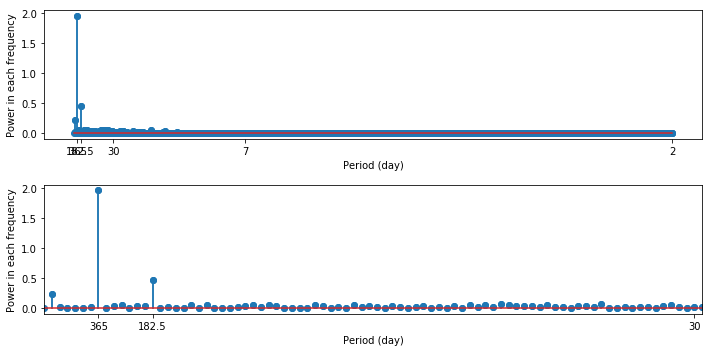

In [27]:
# Complex conjugate does the squaring
Power = (Vspec.conjugate()*Vspec).real
Power *= np.var(Vp) / Power.sum()       # Enforce Parseval's theorem for variance 
fig,(ax1,ax2)=plt.subplots(2,1) 
ax1.stem(freqs, Power)
ax1.set_xticks([7,14,84,365,1278])
ax1.set_xticklabels(['365','182.5','30','7','2']) # convert to periods
ax1.set_xlabel('Period (day)')
ax1.set_ylabel('Power in each frequency')

ax2.stem(freqs, Power)
ax2.set_xticks([7,14,84,365,1278])
ax2.set_xticklabels(['365','182.5','30','7','2'])
ax2.set_xlabel('Period (day)')
ax2.set_ylabel('Power in each frequency')
ax2.set_xlim([0,85])
plt.tight_layout()

print('Variance is', Vp.var(), '$[(W/m^2)^2]$: matches', sum(Power))
# the variance is equal to the sum of power 

### <center>Try another filter function : signal.periodogram

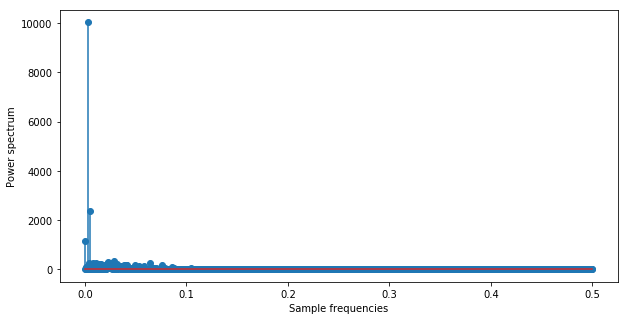

In [28]:
from scipy import signal

f, Pxx = signal.periodogram(Vp) # just put the timeseries in this function
plt.stem(f,Pxx)
plt.ylabel('Power spectrum');plt.xlabel('Sample frequencies');
plt.xticks()
#plt.xlim([0,])
plt.show()


------------
<a name='autocorrelation'></a>
# Autocorrelation and autocovariance 

In [31]:
# Autocovariance 
lags = np.arange(-200,200) # number of lag (day) 
cxx=0.*lags

for ind,tau in enumerate(lags):
    if tau<0:
        cxx[ind]=np.mean(Vp[:tau]*Vp[-tau:]) 
    elif tau==0:
        cxx[ind]=np.mean(Vp*Vp)
    else:
        cxx[ind]=np.mean(Vp[:-tau]*Vp[tau:])
        

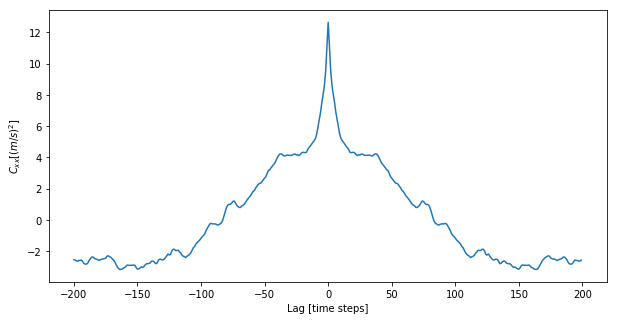

In [36]:
fig,ax=plt.subplots(1,1)
ax.plot(lags,cxx)
ax.set_xlabel('Lag [time steps]')
ax.set_ylabel('$C_{xx} [(m/s)^2]$')
plt.show()

We define the **lag correlation coefficient** as
\begin{equation}
    \rho_{xy}(\tau) = \frac{C_{xy}(\tau)}{\sigma_x\sigma_y}
\end{equation}

This is unitless, and note that $\rho_{xx}(0)=1$.  

(-1, 1)

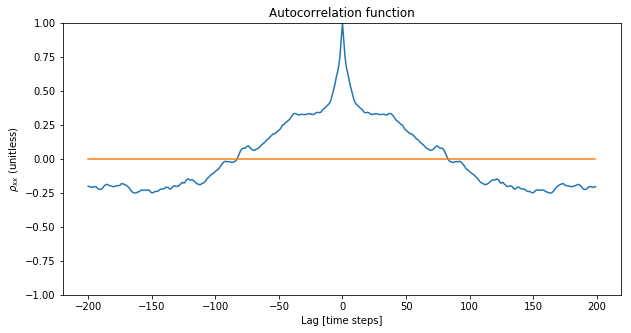

In [37]:
fig,ax=plt.subplots(1,1)

ax.plot(lags,cxx/np.var(Vp))
ax.plot(lags,cxx/np.var(Vp)*0)

ax.set_xlabel('Lag [time steps]')
ax.set_ylabel(r'$\rho_{xx}$ (unitless)')
ax.set_title('Autocorrelation function')

ax.set_ylim([-1,1])

------------

<a name='AR1'></a>
# Autoregression as a model for geophysical "noise"

# Postulate an "explanation" of OLR by prior OLR
$OLR_t = intercept + c \cdot OLR_{t-1} + residual_t$

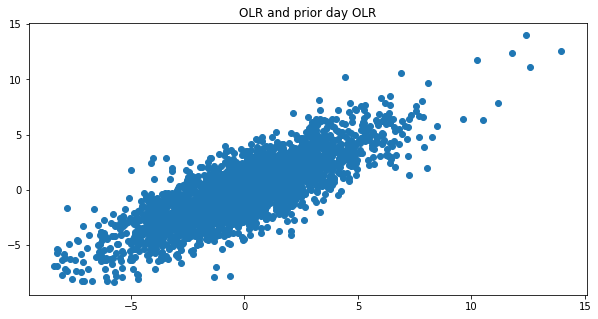

In [75]:
TRUNC = 7 # 7 cycles per record (2555 day)= 1 year

Vspec_trunc = Vspec.copy()
Vspec_trunc[np.where(freqs > TRUNC)] *= 0. # filter 
Vspec_trunc[np.where(freqs < TRUNC)] *= 0.
Vrecon = np.fft.ifft(Vspec_trunc).real # reverse filtered fft back to time series by ifft
olr_a = Vp-Vrecon; # remove annual cycle 

olr_1 = np.roll(olr_a,-1) # same data rolled back one day

fig,ax = plt.subplots(1,1)

ax.scatter(olr_a, olr_1)
ax.set_title('OLR and prior day OLR')
plt.show()

In [76]:
import scipy, scipy.stats

slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(olr_a,olr_1) # linear regression OLR vs OLR_AR1
    
Prediction = intercept + slope*olr_1
print( slope, intercept )
print("r-squared:", r_value**2)

(0.81590734080430372, -1.0491297054555787e-06)
('r-squared:', 0.66570478877835026)


In [77]:
resid = olr_a - Prediction

Text(0.5,1,u'OLR and residual of AR1 prediction')

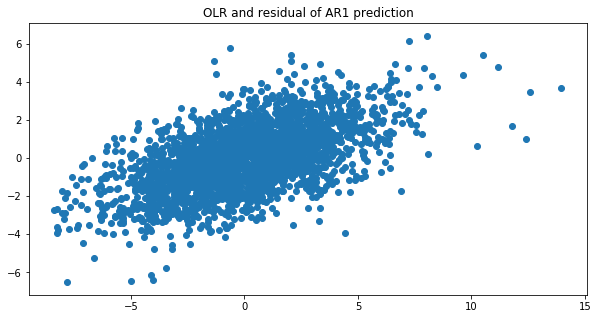

In [79]:
fig,ax = plt.subplots(1,1)

ax.scatter(olr_a, resid)
ax.set_title('OLR and residual of AR1 prediction')

## a really BAD fit -- the residual has strong relationship, there is less "memory " for OLR

#### Model the residual with random noise 